# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
from citipy import citipy
import seaborn
import pandas as pd
import numpy as np
import requests as req
import json
import random
import time
import matplotlib.pyplot as plt
import datetime
import csv
import os

# Pappas API key
api_key = "f9aab612271daa94c397b60a43e0590c"
#url = "http://api.openweathermap.org/data/2.5/forecast?id=524901&APPID={f9aab612271daa94c397b60a43e0590c}"
#units = "imperial" #Fahrenheit

# Output File (CSV)
#output_data_file = "output_data/city_list.csv"

## Generate Cities List

In [2]:
# Generating random latitudes and longitudes
lat = np.random.uniform(low=-90, high=90, size=1500)
lng = np.random.uniform(low=-180, high=180, size=1500)

# Creating coordinate pairs
coordinates = []
for x in range(0,len(lat)):
    coordinates.append((lat[x], lng[x]))

In [5]:
# Finding the cities nearest to the coordinates
cities = []
for coordinate_pair in coordinates:
    lat, lon = coordinate_pair
    cities.append(citipy.nearest_city(lat, lon))

# Creating DataFrame
cities_df = pd.DataFrame(cities)
cities_df["City Name"] = ""
cities_df["Country Code"] = ""

for index, row in cities_df.iterrows():
    row["City Name"] = cities_df.iloc[index,0].city_name
    row["Country Code"] = cities_df.iloc[index,0].country_code

# Dropping duplicate cities
cities_df.drop_duplicates(['City Name', 'Country Code'], inplace=True)
cities_df.reset_index(inplace=True)

# Deleting unnecessary columns
del cities_df[0]
del cities_df['index']

cities_df


,City Name,Country Code
0,ust-barguzin,ru
1,bluff,nz
2,waingapu,id
3,port blair,in
4,mataura,pf
5,rikitea,pf
6,jhajjar,in
7,tahta,eg
8,kropotkin,ru
9,albany,au


In [6]:
cities_df['Latitude'] = ""
cities_df['Longitude'] = ""
cities_df['Temperature (F)'] = ""
cities_df['Humidity (%)'] = ""
cities_df['Cloudiness (%)'] = ""
cities_df['Wind Speed (mph)'] = ""

cities_df

,City Name,Country Code,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,ust-barguzin,ru,,,,,,
1,bluff,nz,,,,,,
2,waingapu,id,,,,,,
3,port blair,in,,,,,,
4,mataura,pf,,,,,,
5,rikitea,pf,,,,,,
6,jhajjar,in,,,,,,
7,tahta,eg,,,,,,
8,kropotkin,ru,,,,,,
9,albany,au,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [7]:
# Accessing data
print("Beginning Data Retrieval")
print("_________________________")

for index, row in cities_df.iterrows():
    # Building target url
    url = "http://api.openweathermap.org/data/2.5/weather?q=%s,%s&units=imperial&appid=%s" % (row['City Name'], row['Country Code'], api_key)
   
    # Printing to ensure loop is correct
    print("Now retrieving City #" + str(index) + ": " + row['City Name'] + ", " + row['Country Code'])
    print(url)
    
    # Running request
    weather_data = req.get(url).json()
    
    try:
        # Appending latitude and longitude to correct location
        row['Latitude'] = weather_data['coord']['lat']
        row['Longitude'] = weather_data['coord']['lon']
    
        # Appending temperature to correct location
        row['Temperature (F)'] = weather_data['main']['temp']
    
        # Appending humidity to correct location
        row['Humidity (%)'] = weather_data['main']['humidity']
    
        # Appending cloudiness to correct location
        row['Cloudiness (%)'] = weather_data['clouds']['all']
    
        # Appending wind speed to correct location
        row['Wind Speed (mph)'] = weather_data['wind']['speed']
    except:
        print("City data error...skipping")
        continue
    
print("_________________________")
print("Data Retrieval Complete")
print("_________________________")

# Changing strings to floats
columns = ['Latitude', 'Temperature (F)', 'Humidity (%)', 'Cloudiness (%)', 'Wind Speed (mph)']
for column in columns:
    cities_df[column] = pd.to_numeric(cities_df[column], errors='coerce')
    
# Dropping NaN values
cities_df.dropna(inplace=True)

cities_df.head(5)

Beginning Data Retrieval
_________________________
Now retrieving City #0: ust-barguzin, ru
http://api.openweathermap.org/data/2.5/weather?q=ust-barguzin,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #1: bluff, nz
http://api.openweathermap.org/data/2.5/weather?q=bluff,nz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #2: waingapu, id
http://api.openweathermap.org/data/2.5/weather?q=waingapu,id&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #3: port blair, in
http://api.openweathermap.org/data/2.5/weather?q=port blair,in&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #4: mataura, pf
http://api.openweathermap.org/data/2.5/weather?q=mataura,pf&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #5: rikitea, pf
http://api.openweathermap.org/data/2.5/weather?q=rikitea,pf&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retr

Now retrieving City #53: bredasdorp, za
http://api.openweathermap.org/data/2.5/weather?q=bredasdorp,za&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #54: dabou, ci
http://api.openweathermap.org/data/2.5/weather?q=dabou,ci&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #55: puerto ayora, ec
http://api.openweathermap.org/data/2.5/weather?q=puerto ayora,ec&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #56: hay river, ca
http://api.openweathermap.org/data/2.5/weather?q=hay river,ca&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #57: anadyr, ru
http://api.openweathermap.org/data/2.5/weather?q=anadyr,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #58: puerto carreno, co
http://api.openweathermap.org/data/2.5/weather?q=puerto carreno,co&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #59: chautla, mx
http://api.openweathermap.org

Now retrieving City #106: mys shmidta, ru
http://api.openweathermap.org/data/2.5/weather?q=mys shmidta,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #107: ewa beach, us
http://api.openweathermap.org/data/2.5/weather?q=ewa beach,us&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #108: alice town, bs
http://api.openweathermap.org/data/2.5/weather?q=alice town,bs&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #109: floriano, br
http://api.openweathermap.org/data/2.5/weather?q=floriano,br&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #110: te horo, nz
http://api.openweathermap.org/data/2.5/weather?q=te horo,nz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #111: akdagmadeni, tr
http://api.openweathermap.org/data/2.5/weather?q=akdagmadeni,tr&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #112: vega de

Now retrieving City #158: kodiak, us
http://api.openweathermap.org/data/2.5/weather?q=kodiak,us&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #159: ahipara, nz
http://api.openweathermap.org/data/2.5/weather?q=ahipara,nz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #160: torbay, ca
http://api.openweathermap.org/data/2.5/weather?q=torbay,ca&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #161: gullhaug, no
http://api.openweathermap.org/data/2.5/weather?q=gullhaug,no&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #162: fort saint john, ca
http://api.openweathermap.org/data/2.5/weather?q=fort saint john,ca&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #163: nanortalik, gl
http://api.openweathermap.org/data/2.5/weather?q=nanortalik,gl&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #164: west wendover, 

Now retrieving City #210: faanui, pf
http://api.openweathermap.org/data/2.5/weather?q=faanui,pf&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #211: kalmunai, lk
http://api.openweathermap.org/data/2.5/weather?q=kalmunai,lk&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #212: labuhan, id
http://api.openweathermap.org/data/2.5/weather?q=labuhan,id&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #213: marcona, pe
http://api.openweathermap.org/data/2.5/weather?q=marcona,pe&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #214: nizhneyansk, ru
http://api.openweathermap.org/data/2.5/weather?q=nizhneyansk,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #215: arawa, pg
http://api.openweathermap.org/data/2.5/weather?q=arawa,pg&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #216: vilh

Now retrieving City #262: alice springs, au
http://api.openweathermap.org/data/2.5/weather?q=alice springs,au&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #263: burgeo, ca
http://api.openweathermap.org/data/2.5/weather?q=burgeo,ca&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #264: pisco, pe
http://api.openweathermap.org/data/2.5/weather?q=pisco,pe&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #265: arraial do cabo, br
http://api.openweathermap.org/data/2.5/weather?q=arraial do cabo,br&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #266: santa maria, cv
http://api.openweathermap.org/data/2.5/weather?q=santa maria,cv&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #267: kahului, us
http://api.openweathermap.org/data/2.5/weather?q=kahului,us&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #268: srednekolymsk, ru
http://api.ope

Now retrieving City #314: grand river south east, mu
http://api.openweathermap.org/data/2.5/weather?q=grand river south east,mu&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #315: bacuit, ph
http://api.openweathermap.org/data/2.5/weather?q=bacuit,ph&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #316: adrar, dz
http://api.openweathermap.org/data/2.5/weather?q=adrar,dz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #317: sataua, ws
http://api.openweathermap.org/data/2.5/weather?q=sataua,ws&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #318: lorengau, pg
http://api.openweathermap.org/data/2.5/weather?q=lorengau,pg&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #319: kizukuri, jp
http://api.openweathermap.org/data/2.5/weather?q=kizukuri,jp&units=imperial&appid=f9aab612271daa

Now retrieving City #366: narsaq, gl
http://api.openweathermap.org/data/2.5/weather?q=narsaq,gl&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #367: peachland, ca
http://api.openweathermap.org/data/2.5/weather?q=peachland,ca&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #368: jos, ng
http://api.openweathermap.org/data/2.5/weather?q=jos,ng&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #369: caravelas, br
http://api.openweathermap.org/data/2.5/weather?q=caravelas,br&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #370: broken hill, au
http://api.openweathermap.org/data/2.5/weather?q=broken hill,au&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #371: coleraine, gb
http://api.openweathermap.org/data/2.5/weather?q=coleraine,gb&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #372: shimoda, jp
http://api.openweathermap.org/data/2.5/w

City data error...skipping
Now retrieving City #419: norman wells, ca
http://api.openweathermap.org/data/2.5/weather?q=norman wells,ca&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #420: ostrovnoy, ru
http://api.openweathermap.org/data/2.5/weather?q=ostrovnoy,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #421: port augusta, au
http://api.openweathermap.org/data/2.5/weather?q=port augusta,au&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #422: khonuu, ru
http://api.openweathermap.org/data/2.5/weather?q=khonuu,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #423: bomet, ke
http://api.openweathermap.org/data/2.5/weather?q=bomet,ke&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #424: bilma, ne
http://api.openweathermap.org/data/2.5/weather?q=bilma,ne&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City 

Now retrieving City #472: hryshkivtsi, ua
http://api.openweathermap.org/data/2.5/weather?q=hryshkivtsi,ua&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #473: irbeyskoye, ru
http://api.openweathermap.org/data/2.5/weather?q=irbeyskoye,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #474: ambilobe, mg
http://api.openweathermap.org/data/2.5/weather?q=ambilobe,mg&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #475: egvekinot, ru
http://api.openweathermap.org/data/2.5/weather?q=egvekinot,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #476: nioro, ml
http://api.openweathermap.org/data/2.5/weather?q=nioro,ml&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #477: coihaique, cl
http://api.openweathermap.org/data/2.5/weather?q=coihaique,cl&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #478: coldwater, us
h

City data error...skipping
Now retrieving City #524: novyy svit, ua
http://api.openweathermap.org/data/2.5/weather?q=novyy svit,ua&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #525: omsukchan, ru
http://api.openweathermap.org/data/2.5/weather?q=omsukchan,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #526: solnechnyy, ru
http://api.openweathermap.org/data/2.5/weather?q=solnechnyy,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #527: hualmay, pe
http://api.openweathermap.org/data/2.5/weather?q=hualmay,pe&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #528: miranda, br
http://api.openweathermap.org/data/2.5/weather?q=miranda,br&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #529: karaton, kz
http://api.openweathermap.org/data/2.5/weather?q=karaton,kz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving Cit

Now retrieving City #576: banikoara, bj
http://api.openweathermap.org/data/2.5/weather?q=banikoara,bj&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #577: olafsvik, is
http://api.openweathermap.org/data/2.5/weather?q=olafsvik,is&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #578: iquitos, pe
http://api.openweathermap.org/data/2.5/weather?q=iquitos,pe&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #579: urdzhar, kz
http://api.openweathermap.org/data/2.5/weather?q=urdzhar,kz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #580: tulagi, sb
http://api.openweathermap.org/data/2.5/weather?q=tulagi,sb&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
City data error...skipping
Now retrieving City #581: presidente medici, br
http://api.openweathermap.org/data/2.5/weather?q=presidente medici,br&units=imperial&appid=f9aab612271daa94

Now retrieving City #628: berbera, so
http://api.openweathermap.org/data/2.5/weather?q=berbera,so&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #629: dzilam gonzalez, mx
http://api.openweathermap.org/data/2.5/weather?q=dzilam gonzalez,mx&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #630: derzhavinsk, kz
http://api.openweathermap.org/data/2.5/weather?q=derzhavinsk,kz&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #631: uige, ao
http://api.openweathermap.org/data/2.5/weather?q=uige,ao&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #632: samarai, pg
http://api.openweathermap.org/data/2.5/weather?q=samarai,pg&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #633: pyra, ru
http://api.openweathermap.org/data/2.5/weather?q=pyra,ru&units=imperial&appid=f9aab612271daa94c397b60a43e0590c
Now retrieving City #634: visby, se
http://api.openweathermap.org/data/2.5/w

,City Name,Country Code,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,ust-barguzin,ru,53.41,109.03,31.33,100.0,80.0,2.06
1,bluff,nz,-46.60,168.33,50.73,100.0,88.0,3.74
2,waingapu,id,-9.65,120.26,78.45,86.0,12.0,4.18
3,port blair,in,11.67,92.75,84.07,100.0,12.0,14.03
5,rikitea,pf,-23.12,-134.97,73.18,100.0,32.0,14.70


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
cities_df.head()

,City Name,Country Code,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,ust-barguzin,ru,53.41,109.03,31.33,100.0,80.0,2.06
1,bluff,nz,-46.60,168.33,50.73,100.0,88.0,3.74
2,waingapu,id,-9.65,120.26,78.45,86.0,12.0,4.18
3,port blair,in,11.67,92.75,84.07,100.0,12.0,14.03
5,rikitea,pf,-23.12,-134.97,73.18,100.0,32.0,14.70


In [31]:
#Exporting to .csv
cities_df.to_csv("Output/weather_data.csv")


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

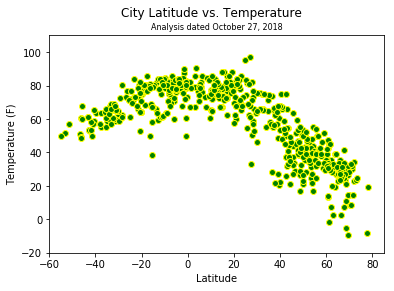

In [39]:
# Axes values
x_axis = cities_df['Latitude']
y_axis = cities_df['Temperature (F)']

plt.scatter(x_axis, y_axis, c='green', edgecolors='yellow')

title_string = "City Latitude vs. Temperature"
subtitle_string = "Analysis dated October 27, 2018"

plt.suptitle(title_string, y=.98, fontsize=12)
plt.title(subtitle_string, fontsize=8)

plt.xlabel("Latitude")
plt.xlim(-60,85)
plt.ylabel("Temperature (F)")
plt.ylim(-20,110)

plt.savefig("Images/latitude_vs_temperature.png")
plt.show()

#### Latitude vs. Humidity Plot

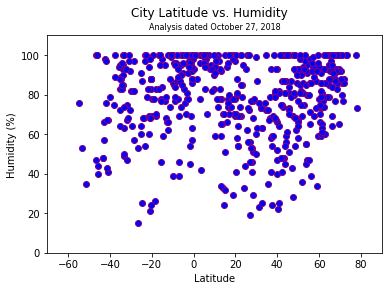

In [40]:
# Axes values
x_axis = cities_df['Latitude']
y_axis = cities_df['Humidity (%)']

title_string = "City Latitude vs. Humidity"
subtitle_string = "Analysis dated October 27, 2018"

plt.suptitle(title_string, y=.98, fontsize=12)
plt.title(subtitle_string, fontsize=8)

plt.scatter(x_axis, y_axis, c='blue', edgecolors='purple', alpha=1)

plt.xlabel("Latitude")
plt.xlim(-70,90)
plt.ylabel("Humidity (%)")
plt.ylim(0,110)

plt.savefig("Images/latitude_vs_humidity.png")
plt.show()

#### Latitude vs. Cloudiness Plot

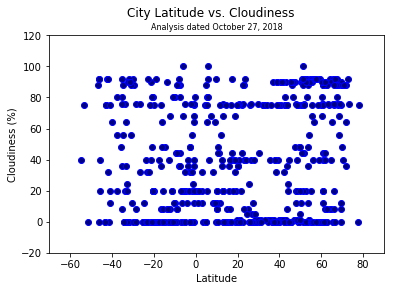

In [41]:
# Axes values
x_axis = cities_df['Latitude']
y_axis = cities_df['Cloudiness (%)']

plt.scatter(x_axis, y_axis, c='navy', edgecolors='blue', alpha=1)

title_string = "City Latitude vs. Cloudiness"
subtitle_string = "Analysis dated October 27, 2018"

plt.suptitle(title_string, y=.98, fontsize=12)
plt.title(subtitle_string, fontsize=8)

plt.xlabel("Latitude")
plt.xlim(-70,90)
plt.ylabel("Cloudiness (%)")
plt.ylim(-20,120)

plt.savefig("Images/latitude_vs_cloudiness.png")
plt.show()

#### Latitude vs. Wind Speed Plot

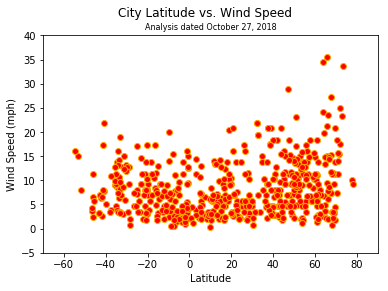

In [42]:
# Axes values
x_axis = cities_df['Latitude']
y_axis = cities_df['Wind Speed (mph)']

plt.scatter(x_axis, y_axis, c='red', edgecolors='orange', alpha=1)

title_string = "City Latitude vs. Wind Speed"
subtitle_string = "Analysis dated October 27, 2018"

plt.suptitle(title_string, y=.98, fontsize=12)
plt.title(subtitle_string, fontsize=8)

plt.xlabel("Latitude")
plt.xlim(-70,90)
plt.ylabel("Wind Speed (mph)")
plt.ylim(-5,40)

plt.savefig("Images/latitude_vs_windspeed.png")
plt.show()